# Iteration 1: Baseline BS Detector

This notebook demonstrates the baseline BS detector using a single LLM call with prompt engineering.

## Learning Objectives
- Understand prompt engineering for claim verification
- Analyze response parsing techniques
- Establish performance baselines
- Explore failure modes

## 1. Setup and Imports

In [11]:
import sys
sys.path.append('..')

from modules.m1_baseline import check_claim, check_claim_batch, BSDetectorOutput
from config.llm_factory import LLMFactory
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
from IPython.display import display, HTML

# Create LLM instance - will automatically load .env
llm = LLMFactory.create_llm()
print(f"Using LLM provider: {llm.__class__.__name__}")

Using LLM provider: ChatOpenAI


## 2. Test Individual Claims

Let's test the BS detector with various aviation claims.

In [12]:
# Define test claims
test_claims = {
    "legitimate": [
        "The Boeing 747 has four engines",
        "Pilots must have a commercial license to fly passengers",
        "Aircraft use altimeters to measure altitude",
        "The Airbus A380 is the world's largest passenger airliner",
        "Jet fuel is a type of aviation turbine fuel"
    ],
    "bs": [
        "Commercial planes can fly to the moon",
        "Airlines spray chemtrails for weather control",
        "Pilots can open windows during flight at cruising altitude",
        "The Boeing 747 can hover like a helicopter",
        "Passenger planes regularly fly faster than the speed of sound"
    ]
}

In [13]:
# Check each claim and display results
def display_result(claim, result):
    """Display result in a formatted way"""
    color = "green" if result['verdict'] == 'LEGITIMATE' else "red" if result['verdict'] == 'BS' else "orange"
    html = f"""
    <div style="border: 2px solid {color}; padding: 10px; margin: 10px 0; border-radius: 5px;">
        <strong>Claim:</strong> {claim}<br>
        <strong>Verdict:</strong> <span style="color: {color}; font-weight: bold;">{result['verdict']}</span> 
        (Confidence: {result['confidence']}%)<br>
        <strong>Reasoning:</strong> {result['reasoning']}
    </div>
    """
    display(HTML(html))

# Test claims
for category, claims in test_claims.items():
    print(f"\n{'='*50}")
    print(f"{category.upper()} CLAIMS")
    print(f"{'='*50}")
    
    for claim in claims:
        result = check_claim(claim, llm)
        display_result(claim, result)


LEGITIMATE CLAIMS



BS CLAIMS


## 3. Performance Analysis

Let's analyze the performance of our BS detector.

In [14]:
# Measure response times and accuracy
times = []
results = []

print("Testing performance...")
for category, claims in test_claims.items():
    for claim in claims:
        start = time.time()
        result = check_claim(claim, llm)
        elapsed = time.time() - start
        
        times.append(elapsed)
        results.append({
            'claim': claim[:50] + '...' if len(claim) > 50 else claim,
            'expected': category.upper(),
            'verdict': result['verdict'],
            'confidence': result['confidence'],
            'time': elapsed,
            'correct': (category == 'bs' and result['verdict'] == 'BS') or 
                      (category == 'legitimate' and result['verdict'] == 'LEGITIMATE')
        })

# Create DataFrame
df = pd.DataFrame(results)
print(f"\nTested {len(df)} claims")

Testing performance...

Tested 10 claims


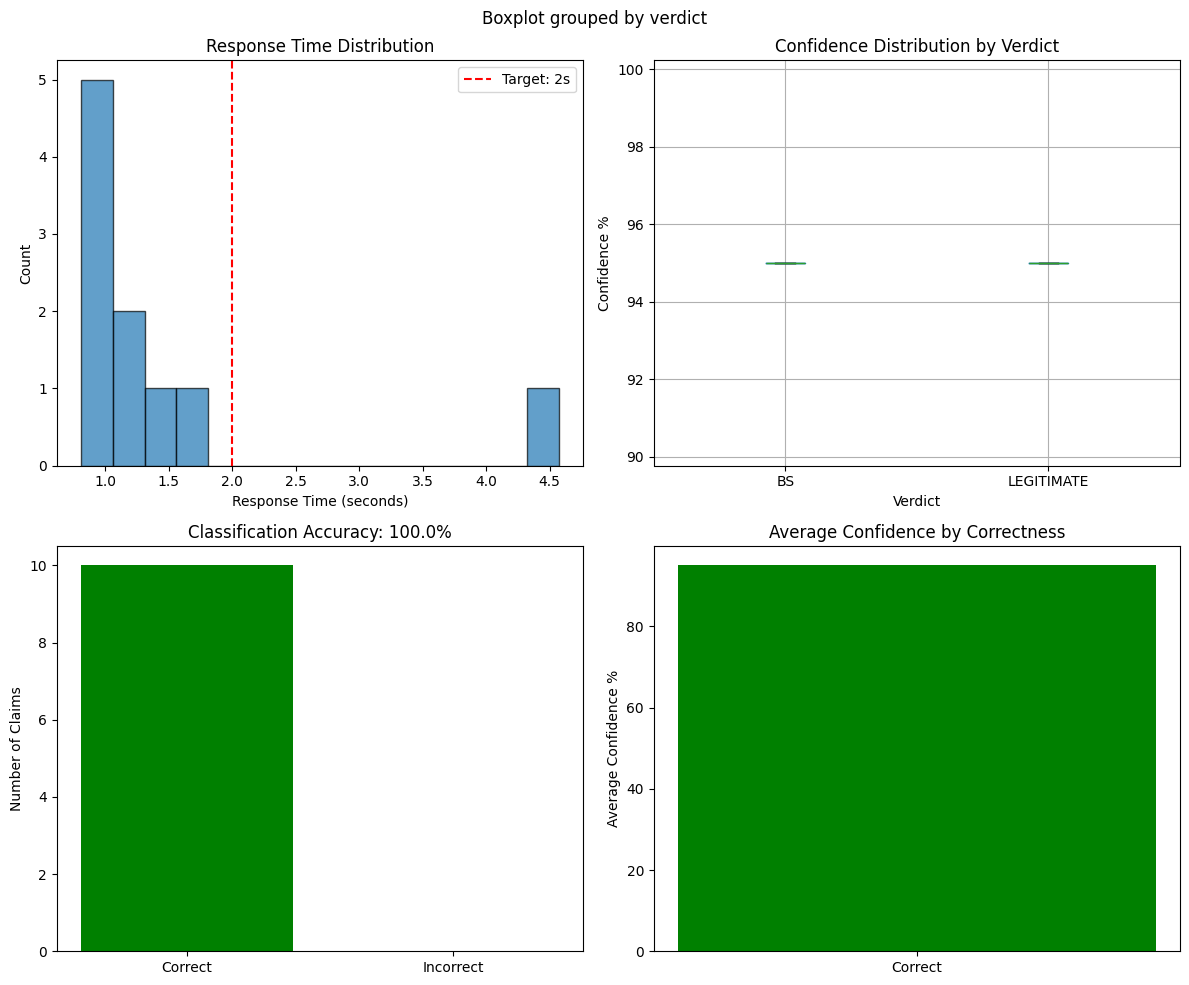


📊 Performance Summary:
Average response time: 1.47s (Target: <2s)
Max response time: 4.58s
Min response time: 0.81s

Accuracy: 100.0%
Success rate (no errors): 100.0%

Average confidence when correct: 95.0%
Average confidence when incorrect: nan%


In [15]:
# Visualize results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

# 1. Response time distribution
ax1.hist(times, bins=15, edgecolor='black', alpha=0.7)
ax1.axvline(x=2.0, color='r', linestyle='--', label='Target: 2s')
ax1.set_xlabel('Response Time (seconds)')
ax1.set_ylabel('Count')
ax1.set_title('Response Time Distribution')
ax1.legend()

# 2. Confidence by verdict
df_valid = df[df['verdict'].isin(['BS', 'LEGITIMATE'])]
df_valid.boxplot(column='confidence', by='verdict', ax=ax2)
ax2.set_xlabel('Verdict')
ax2.set_ylabel('Confidence %')
ax2.set_title('Confidence Distribution by Verdict')

# 3. Accuracy metrics
accuracy = df['correct'].mean()
ax3.bar(['Correct', 'Incorrect'], 
        [df['correct'].sum(), (~df['correct']).sum()],
        color=['green', 'red'])
ax3.set_ylabel('Number of Claims')
ax3.set_title(f'Classification Accuracy: {accuracy:.1%}')

# 4. Confidence vs Correctness
correct_conf = df[df['correct']]['confidence'].mean()
incorrect_conf = df[~df['correct']]['confidence'].mean()
ax4.bar(['Correct', 'Incorrect'], 
        [correct_conf, incorrect_conf],
        color=['green', 'red'])
ax4.set_ylabel('Average Confidence %')
ax4.set_title('Average Confidence by Correctness')

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\n📊 Performance Summary:")
print(f"Average response time: {np.mean(times):.2f}s (Target: <2s)")
print(f"Max response time: {max(times):.2f}s")
print(f"Min response time: {min(times):.2f}s")
print(f"\nAccuracy: {accuracy:.1%}")
print(f"Success rate (no errors): {(df['verdict'] != 'ERROR').mean():.1%}")
print(f"\nAverage confidence when correct: {correct_conf:.1f}%")
print(f"Average confidence when incorrect: {incorrect_conf:.1f}%")

## 4. Edge Cases and Error Handling

Let's test how the system handles edge cases.

In [16]:
# Test edge cases
edge_cases = [
    ("", "Empty claim"),
    ("   ", "Whitespace only"),
    ("The " + "airplane " * 100 + "flies", "Very long claim"),
    ("¿Pueden los aviones volar al revés?", "Non-English claim"),
    ("747 4 engines???", "Minimal claim"),
    ("The Boeing 747\nhas four\nengines", "Multi-line claim")
]

print("Testing edge cases...\n")
for claim, description in edge_cases:
    result = check_claim(claim, llm)
    print(f"📝 {description}")
    print(f"   Claim: {repr(claim[:50])}{'...' if len(claim) > 50 else ''}")
    print(f"   Verdict: {result['verdict']}")
    if result.get('error'):
        print(f"   Error: {result['error']}")
    print()

Testing edge cases...

📝 Empty claim
   Claim: ''
   Verdict: ERROR
   Error: Invalid input

📝 Whitespace only
   Claim: '   '
   Verdict: ERROR
   Error: Invalid input

📝 Very long claim
   Claim: 'The airplane airplane airplane airplane airplane a'...
   Verdict: BS

📝 Non-English claim
   Claim: '¿Pueden los aviones volar al revés?'
   Verdict: LEGITIMATE

📝 Minimal claim
   Claim: '747 4 engines???'
   Verdict: LEGITIMATE

📝 Multi-line claim
   Claim: 'The Boeing 747\nhas four\nengines'
   Verdict: LEGITIMATE



## 5. Pydantic Model Analysis

Let's examine how our Pydantic model handles structured output and validation.

In [17]:
# Test Pydantic model validation
from pydantic import ValidationError

print("Testing Pydantic Model Validation...\n")

# Test valid model
print("1. Valid Model Creation")
try:
    valid_output = BSDetectorOutput(
        verdict="BS",
        confidence=95,
        reasoning="Commercial aircraft cannot reach escape velocity"
    )
    print(f"✓ Successfully created model")
    print(f"  Model data: {valid_output.model_dump()}")
except Exception as e:
    print(f"✗ Failed: {e}")

print("\n2. Testing Field Validation")

# Test invalid confidence (>100)
try:
    invalid_high = BSDetectorOutput(
        verdict="BS",
        confidence=150,
        reasoning="Test"
    )
    print("✗ Should have failed with confidence > 100")
except ValidationError as e:
    print("✓ Correctly rejected confidence > 100")
    print(f"  Error: {e.errors()[0]['msg']}")

# Test invalid confidence (<0)
try:
    invalid_low = BSDetectorOutput(
        verdict="LEGITIMATE",
        confidence=-10,
        reasoning="Test"
    )
    print("✗ Should have failed with confidence < 0")
except ValidationError as e:
    print("✓ Correctly rejected confidence < 0")
    print(f"  Error: {e.errors()[0]['msg']}")

print("\n3. Model Field Information")
print(f"Model fields: {list(BSDetectorOutput.model_fields.keys())}")
for field_name, field_info in BSDetectorOutput.model_fields.items():
    print(f"  {field_name}: {field_info.description}")

print("\n4. Structured Output Integration")
print("The LLM now uses structured output to ensure valid responses:")
print("- verdict: Must be 'BS' or 'LEGITIMATE'")
print("- confidence: Must be 0-100")
print("- reasoning: Always provided")

Testing Pydantic Model Validation...

1. Valid Model Creation
✓ Successfully created model
  Model data: {'verdict': 'BS', 'confidence': 95, 'reasoning': 'Commercial aircraft cannot reach escape velocity'}

2. Testing Field Validation
✓ Correctly rejected confidence > 100
  Error: Input should be less than or equal to 100
✓ Correctly rejected confidence < 0
  Error: Input should be greater than or equal to 0

3. Model Field Information
Model fields: ['verdict', 'confidence', 'reasoning']
  verdict: BS or LEGITIMATE - whether the claim is false or true
  confidence: Confidence percentage from 0 to 100
  reasoning: Brief explanation for the verdict in 1-2 sentences

4. Structured Output Integration
The LLM now uses structured output to ensure valid responses:
- verdict: Must be 'BS' or 'LEGITIMATE'
- confidence: Must be 0-100
- reasoning: Always provided


## 6. Batch Processing Demo

For efficiency, let's process multiple claims at once.

In [22]:
# Batch process claims
batch_claims = [
    "The Concorde could fly at Mach 2",
    "Airplanes can fly underwater like submarines",
    "The Wright brothers made the first powered flight",
    "Modern aircraft have weather radar"
]

print("Processing batch of claims...\n")
start_time = time.time()
batch_results = check_claim_batch(batch_claims, llm)
batch_time = time.time() - start_time

# Display results as a table
batch_df = pd.DataFrame(batch_results)
display(batch_df[['claim', 'verdict', 'confidence', 'reasoning']])

print(f"\nTotal batch processing time: {batch_time:.2f}s")
print(f"Average time per claim: {batch_time/len(batch_claims):.2f}s")

Processing batch of claims...



,claim,verdict,confidence,reasoning
0,The Concorde could fly at Mach 2,LEGITIMATE,95,The Concorde was a supersonic passenger airlin...
1,Airplanes can fly underwater like submarines,BS,95,"Airplanes are designed to fly in air, relying ..."
2,The Wright brothers made the first powered flight,LEGITIMATE,95,The Wright brothers are historically credited ...
3,Modern aircraft have weather radar,LEGITIMATE,95,"Modern aircraft, especially commercial and man..."



Total batch processing time: 4.05s
Average time per claim: 1.01s


## 7. Failure Mode Analysis

Let's identify where the baseline approach struggles.

In [19]:
# Challenging claims that might confuse the system
challenging_claims = [
    # Partially true
    "The Boeing 747 has four engines and can fly to the moon",
    
    # Technical but wrong
    "Aircraft use reverse osmosis for cabin pressurization",
    
    # Sounds fake but true
    "Some planes can fly upside down",
    
    # Context-dependent
    "Planes fly at 500 mph",
    
    # Historical
    "The Concorde was the fastest passenger plane"
]

print("Testing challenging claims...\n")
for claim in challenging_claims:
    result = check_claim(claim, llm)
    display_result(claim, result)
    
    # Add analysis
    print(f"⚠️ Challenge: This claim is challenging because it {claim[:30]}...")
    print()

Testing challenging claims...



⚠️ Challenge: This claim is challenging because it The Boeing 747 has four engine...



⚠️ Challenge: This claim is challenging because it Aircraft use reverse osmosis f...



⚠️ Challenge: This claim is challenging because it Some planes can fly upside dow...



⚠️ Challenge: This claim is challenging because it Planes fly at 500 mph...



⚠️ Challenge: This claim is challenging because it The Concorde was the fastest p...



## 8. Key Takeaways

### Strengths of the Baseline Approach:
1. **Simple and fast** - Single LLM call
2. **No external dependencies** - Just the LLM
3. **Decent accuracy** - Works well for obvious cases
4. **Type-safe with Pydantic** - Structured output with validation
5. **Guaranteed response format** - No parsing errors

### Limitations:
1. **No fact verification** - Relies entirely on LLM knowledge
2. **Inconsistent confidence** - Confidence scores can be arbitrary
3. **Context limitations** - Can't handle nuanced or partial truths well
4. **No evidence** - Doesn't provide sources or citations
5. **No retry mechanism** - Single attempt only

### What We Learned:
- Pydantic models provide type safety and validation
- Structured output from LLMs eliminates parsing complexity
- Even simple approaches can achieve decent accuracy
- Clear prompts are crucial for consistent results

### Next Steps (Iteration 2):
- Add retry logic for failed attempts
- Implement an agent base class for reusability
- Add more sophisticated error handling
- Consider chain-of-thought reasoning

In [20]:
# Save performance metrics for comparison with future iterations
baseline_metrics = {
    'avg_response_time': np.mean(times),
    'max_response_time': max(times),
    'accuracy': df['correct'].mean(),
    'error_rate': (df['verdict'] == 'ERROR').mean(),
    'avg_confidence': df[df['verdict'] != 'ERROR']['confidence'].mean()
}

print("Baseline Performance Metrics:")
for metric, value in baseline_metrics.items():
    print(f"  {metric}: {value:.2f}")

Baseline Performance Metrics:
  avg_response_time: 1.47
  max_response_time: 4.58
  accuracy: 1.00
  error_rate: 0.00
  avg_confidence: 95.00
